In [1]:
import os
import shutil
import random
import glob

import tensorflow as tf
from tensorflow.keras.preprocessing.image import  ImageDataGenerator
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
vgg16_model = tf.keras.applications.vgg16.VGG16()


In [ ]:
#plot_model(vgg16_model)

In [ ]:
#vgg16_model.summary()


## vgg16 summary
input layer >> 5 blocks >> flatten >> 2 dense layers >> output layer

### Blocks
 
#### Block 1 & Block 2: 

Two conv layers (each with 64 filters in block 1 and 128 filters block 2), zero padding(image dimensions preserved), one max pooling layer - 2x2 with a stride of 2 (image dimensions are reduced in half)

#### Block 3 - Block 5:

3 conv layers (256 filters >> 512 for 4 and 5), max pooling layer

#### Flatten layer
Block 5 max pooling output 7 * 7 * 512 = 25088

2 Dense layers 4096 units each

output layer: 1000 units for 1000 classes

23 total layers

## Convolution operation
nxn image

output  = (n - f + 1)  X (n - f + 1)

## Maxpooling
Reduce computational load

Reduce overfitting: Pick only the most activated pixels  and discard the low. The model learns what to identify and what not to

# Data preprocessing

In [ ]:
os.chdir('/content/drive/MyDrive/Dataset2/')

In [ ]:
train_path2 = '/content/drive/MyDrive/Dataset2/train'
valid_path2 = '/content/drive/MyDrive/Dataset2/valid'
test_path2 =  '/content/drive/MyDrive/Dataset2/test'

In [ ]:
data_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
train_batches2 = data_gen.flow_from_directory(directory=train_path2, 
                                               target_size=(224,224),
                                               classes = ['NORMAL','PNEUMONIA'],
                                               batch_size=10)

valid_batches2 = data_gen.flow_from_directory(directory=valid_path2, 
                                               target_size=(224,224),
                                               classes = ['NORMAL','PNEUMONIA'],
                                               batch_size=10)

test_batches2 = data_gen.flow_from_directory(directory=test_path2, 
                                               target_size=(224,224),
                                               classes = ['NORMAL','PNEUMONIA'],
                                               batch_size=10,
                                             shuffle = False)


## Predictions before Transfer Learning

In [ ]:
test_IMG ='/content/drive/MyDrive/Dataset2/test/NORMAL/NORMAL0NORMAL2-IM-1427-0001.jpeg'
test_IMG

In [ ]:
def prepare_image_vgg16(file):
    #load image from file
    image = load_img(file, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # same as np.expand_dims(img_array, axis=0)
    return tf.keras.applications.vgg16.preprocess_input(image)

In [ ]:
image = prepare_image_vgg16(test_IMG)
plt.imshow(tf.squeeze(image))# squeeze removes the extra dimension added when preparing the image 
# for matplotlib to display the image

In [ ]:
# predict the probability across all output classes
yhat = vgg16_model.predict(image)
#yhat

In [ ]:
# convert the probabilities to class labels
label = decode_predictions(yhat)
label

In [ ]:
# retrieve the most likely result, e.g. highest probability
label = label[0][0]
label

In [ ]:
# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))

### Summary
Highest prediction: conch (32.02%)

all predictions:

[[('n01943899', 'conch', 0.32015178),
  ('n04557648', 'water_bottle', 0.19363283),
  ('n04590129', 'window_shade', 0.07608834),
  ('n01990800', 'isopod', 0.05376595),
  ('n03637318', 'lampshade', 0.023107912)]]


Conch (/kɒŋk, kɒntʃ/) is a common name of a number of different medium-to-large-sized sea snails.

Its clear  that chest x-rays were not in the imagenet dataset

# Transfer Learning  
Here we adapt the vgg16 model to our custom data set.  
We transfer what the model learnt on the imagenet dataset to classifying chest x-rays as either Pneunomia or Normal. 

To do this, we determine the number of layers to retrain.  
Specifically, we take the following steps:  
<ol>
  <li>Determine the index of the layers having parameters </li>
  <li>Retrain the vgg16 model saving the different variations</li>
  <li>Evaluate the diiferent models on the test set</li>
  <li>Pick the best model</li>
  <li>Proceed to model deployment</li>  
</ol>

### Parameter Layers 

In [3]:
#n in parameter layers is counted from the last layer, excluding the output layer
all_parameter_layers = [2, 5, 6, 7, 9, 10, 11, 13, 14, 15, 17, 18, 20, 21]
#half the layers with trainable parameters starting from second last
parameter_layers = [ 2, 5, 7, 10, 13, 15, 18, 20]

### Training Different variations

In [ ]:
#half the layers with trainable parameters starting from second last
parameter_layers = [ 2, 5, 7, 10, 13, 15, 18, 20] 
for n in parameter_layers:
  print(n)
  vgg16_model = tf.keras.applications.vgg16.VGG16()
  model = Sequential()
  for layer in vgg16_model.layers[:-1]:
      model.add(layer)

  for layer in model.layers[:-n]:
    layer.trainable = False
    
  model.add(Dense(units=2, activation='softmax'))
  model.summary()
  print()

  model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

  history = model.fit(x=train_batches2,
      steps_per_epoch = len(train_batches2),
      validation_data = valid_batches2,
      validation_steps = len(valid_batches2),
      epochs=10,
      verbose=2
  )

  model.save(f"vgg16-{n}.h5")


### Creating a dataframe of evaluation metrics

In [ ]:
test_batches2.class_indices,test_batches2.classes

In [ ]:
df = pd.DataFrame(columns = ["Layers_retrained",
                             "Accuracy", "Precision", "Recall","F1-score",
                             ])

In [ ]:
# n in parameter layers is counted from the last layer, excluding the output layer
parameter_layers = [ 2, 5, 7, 10, 13, 15, 18, 20, 21] 

In [ ]:
n = 21
new_model = tf.keras.models.load_model(f"vgg16-{n}.h5")

In [ ]:
predictions = new_model.predict(x=test_batches2, steps=len(test_batches2), verbose=0)
y_pred = np.argmax(predictions, axis=-1) #returns the indices of the max value along the rows

In [ ]:
def accuracy(true_labels , predicted_labels):
    m = tf.keras.metrics.Accuracy()
    m.update_state(true_labels,predicted_labels )
    return m.result().numpy()

def precision(true_labels , predicted_labels):
    m = tf.keras.metrics.Precision()
    m.update_state(true_labels,predicted_labels )
    return m.result().numpy()

def recall(true_labels , predicted_labels):
    m = tf.keras.metrics.Recall()
    m.update_state(true_labels,predicted_labels )
    return m.result().numpy()

from sklearn.metrics import f1_score
def f_score(true_labels , predicted_labels):
  return f1_score(true_labels , predicted_labels)

In [ ]:
acc = accuracy(true_labels = test_batches2.classes,
                      predicted_labels = y_pred)
print(f'accuracy: {acc}')

precsn = precision(true_labels = test_batches2.classes,
                    predicted_labels = y_pred)
print(f'precision: {precsn}')

recll = recall(true_labels = test_batches2.classes,
                    predicted_labels = y_pred)
print(f'recall: {recll}')

f1_score = f_score(true_labels = test_batches2.classes,
                    predicted_labels = y_pred)
print(f'f1-score: {f1_score}')

# layers_retrained = n + output_layer
df = df.append([{"Layers_retrained" : f"{n + 1}",
            "Accuracy" : acc,
            "Precision": precsn,
           "Recall" : recll,
            "F1-score" :f1_score }],
          ignore_index = True)
df

In [ ]:
file_name = 'balanced-vgg16-evaluation2.xlsx'
df.to_excel(file_name)
print('DataFrame is written to Excel File successfully.')

### Visualizing predictions
#### Trained on half unbalanced dataset

In [7]:
data = {'Layers_retrained':[3,6,8,11,14,16,19,21,22],
       'Accuracy':[0.968354, 0.971519, 0.971519, 0.933544, 0.933544, 0.946203, 0.952532, 0.955696, 0.939873],
       'Precision':[0.951219, 0.968553, 0.980645, 0.882682, 0.900585, 0.954839, 0.938650, 0.939024, 0.948387],
       'Recall':[0.987342, 0.974684, 0.962025, 1.000000, 0.974684, 0.936709, 0.968354, 0.974684, 0.930380],
       'F1-score':[0.968944, 0.971609, 0.971246, 0.937685, 0.936170, 0.945687, 0.953271, 0.956522, 0.939297]}


In [8]:
df = pd.DataFrame(data)
df = df.set_index('Layers_retrained')
df

,Accuracy,Precision,Recall,F1-score
Layers_retrained,,,,
3,0.968354,0.951219,0.987342,0.968944
6,0.971519,0.968553,0.974684,0.971609
8,0.971519,0.980645,0.962025,0.971246
11,0.933544,0.882682,1.000000,0.937685
14,0.933544,0.900585,0.974684,0.936170
16,0.946203,0.954839,0.936709,0.945687
19,0.952532,0.938650,0.968354,0.953271
21,0.955696,0.939024,0.974684,0.956522
22,0.939873,0.948387,0.930380,0.939297


<AxesSubplot:xlabel='Layers_retrained'>

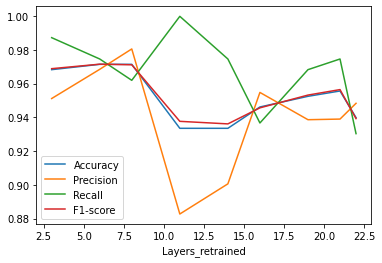

In [9]:
df.plot()

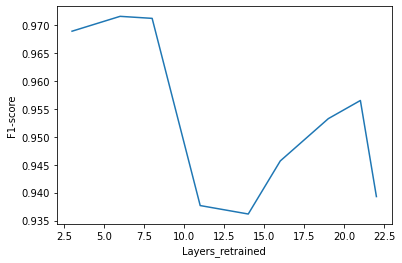

In [12]:
plt.plot(df['F1-score'])
plt.xlabel('Layers_retrained')
plt.ylabel('F1-score')
plt.show()

### Visualizing the evaluations
#### Trained on balanced dataset

In [24]:
os.chdir(r'C:\Users\HR\pycharm\projects\pneumonia-test\Dataset2\\')

In [25]:
df1 = pd.read_excel('balanced-vgg16-evaluation.xlsx')
df2 = pd.read_excel('balanced-vgg16-evaluation2.xlsx')
df1,print(), df2

(   Unnamed: 0  Layers_retrained  Accuracy  Precision    Recall  F1-score
 0           0                 3  0.965190   0.980392  0.949367  0.964630
 1           1                 6  0.962025   0.962025  0.962025  0.962025
 2           2                 8  0.955696   1.000000  0.911392  0.953642
 3           3                11  0.962025   0.980263  0.943038  0.961290
 4           4                14  0.968354   0.974359  0.962025  0.968153
 5           5                16  0.971519   0.974522  0.968354  0.971429,
 None,
    Unnamed: 0  Layers_retrained  Accuracy  Precision    Recall  F1-score
 0           0                19  0.955696   0.961538  0.949367  0.955414
 1           1                21  0.952532   0.986395  0.917722  0.950820
 2           2                22  0.955696   0.939024  0.974684  0.956522)

In [26]:
data = [df1, df2]
full_df = pd.concat(data)
full_df

,Unnamed: 0,Layers_retrained,Accuracy,Precision,Recall,F1-score
0,0,3,0.965190,0.980392,0.949367,0.964630
1,1,6,0.962025,0.962025,0.962025,0.962025
2,2,8,0.955696,1.000000,0.911392,0.953642
3,3,11,0.962025,0.980263,0.943038,0.961290
4,4,14,0.968354,0.974359,0.962025,0.968153
5,5,16,0.971519,0.974522,0.968354,0.971429
0,0,19,0.955696,0.961538,0.949367,0.955414
1,1,21,0.952532,0.986395,0.917722,0.950820
2,2,22,0.955696,0.939024,0.974684,0.956522


In [27]:
full_df.columns

Index(['Unnamed: 0', 'Layers_retrained', 'Accuracy', 'Precision', 'Recall',
       'F1-score'],
      dtype='object')

In [28]:
del(full_df['Unnamed: 0'])

In [29]:
full_df = full_df.set_index('Layers_retrained')
file_name = 'vgg16-blncd-metrics.xlsx'
full_df.to_excel(file_name)
full_df

,Accuracy,Precision,Recall,F1-score
Layers_retrained,,,,
3,0.965190,0.980392,0.949367,0.964630
6,0.962025,0.962025,0.962025,0.962025
8,0.955696,1.000000,0.911392,0.953642
11,0.962025,0.980263,0.943038,0.961290
14,0.968354,0.974359,0.962025,0.968153
16,0.971519,0.974522,0.968354,0.971429
19,0.955696,0.961538,0.949367,0.955414
21,0.952532,0.986395,0.917722,0.950820
22,0.955696,0.939024,0.974684,0.956522


<AxesSubplot:xlabel='Layers_retrained'>

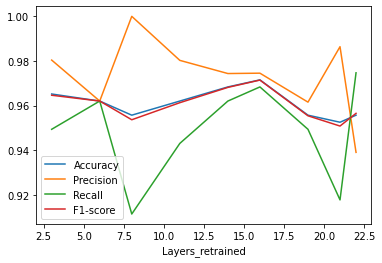

In [17]:
full_df.plot()

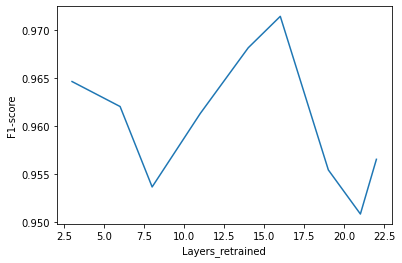

In [18]:
plt.plot(full_df['F1-score'])
plt.xlabel('Layers_retrained')
plt.ylabel('F1-score')
plt.show()

### Comparing f1-scores of models trained on the balanced dataset and unbalanced

#### Unbalanced 

In [19]:
data_unbalanced = {'Layers_retrained':[3,6,8,11,14,16,19,21,22],
       'Accuracy':[0.968354, 0.971519, 0.971519, 0.933544, 0.933544, 0.946203, 0.952532, 0.955696, 0.939873],
       'Precision':[0.951219, 0.968553, 0.980645, 0.882682, 0.900585, 0.954839, 0.938650, 0.939024, 0.948387],
       'Recall':[0.987342, 0.974684, 0.962025, 1.000000, 0.974684, 0.936709, 0.968354, 0.974684, 0.930380],
       'F1-score':[0.968944, 0.971609, 0.971246, 0.937685, 0.936170, 0.945687, 0.953271, 0.956522, 0.939297]}


In [79]:
df_unbalanced = pd.DataFrame(data_unbalanced)
df_unbalanced = df_unbalanced.set_index('Layers_retrained')
df_unbalanced

,Accuracy,Precision,Recall,F1-score
Layers_retrained,,,,
3,0.968354,0.951219,0.987342,0.968944
6,0.971519,0.968553,0.974684,0.971609
8,0.971519,0.980645,0.962025,0.971246
11,0.933544,0.882682,1.000000,0.937685
14,0.933544,0.900585,0.974684,0.936170
16,0.946203,0.954839,0.936709,0.945687
19,0.952532,0.938650,0.968354,0.953271
21,0.955696,0.939024,0.974684,0.956522
22,0.939873,0.948387,0.930380,0.939297


#### Balanced

In [32]:
df_balanced = pd.read_excel('vgg16-blncd-metrics.xlsx')
df_balanced = df_balanced.set_index('Layers_retrained')
df_balanced

,Accuracy,Precision,Recall,F1-score
Layers_retrained,,,,
3,0.965190,0.980392,0.949367,0.964630
6,0.962025,0.962025,0.962025,0.962025
8,0.955696,1.000000,0.911392,0.953642
11,0.962025,0.980263,0.943038,0.961290
14,0.968354,0.974359,0.962025,0.968153
16,0.971519,0.974522,0.968354,0.971429
19,0.955696,0.961538,0.949367,0.955414
21,0.952532,0.986395,0.917722,0.950820
22,0.955696,0.939024,0.974684,0.956522


#### All metrics

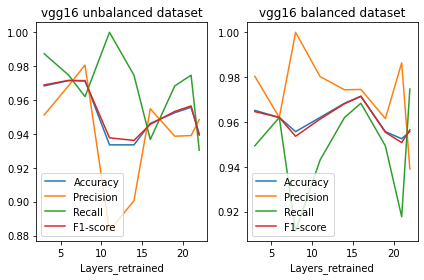

In [77]:
figure, axes = plt.subplots(1, 2)
df_unbalanced.plot(ax=axes[0])
axes[0].set_title('vgg16 unbalanced dataset')


df_balanced.plot(ax=axes[1])
axes[1].set_title('vgg16 balanced dataset')

figure.tight_layout()


#### F1 scores

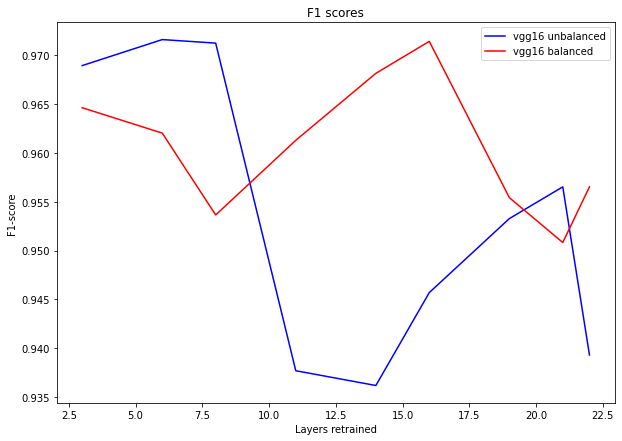

In [91]:
plt.figure(figsize = (10,7))
plt.plot(df_unbalanced['F1-score'], color = 'blue', label = 'vgg16 unbalanced')
plt.plot(df_balanced['F1-score'],color = 'red', label = 'vgg16 balanced')
plt.xlabel('Layers retrained')
plt.ylabel('F1-score')
plt.legend()
plt.title('F1 scores')
plt.show()

# Analysis
parameter_layers = [2, 5, 6, 7, 9, 10, 11, 13, 14, 15, 17, 18, 20, 21]

### Unbalanced Dataset  
#### Best option
Layers to retrain = (5 or 7) + output layer  
f-scores: 0.971609, 0.971246  
#### Deent options
layers: 2 + output_layer  
f-score: 0.968944

### Balanced dataset  
#### Best option
Layers = 15 + output layer  
f-score: 0.971429
#### Decent options
Layers = (2, 5, 10, 13) + output layer  
f-scores: 0.964630, 0.962025, 0.961290, 0.968153